# Assignment - CT100-3-M Deep Learning

Concrete crack image classification using **augmented** dataset by introducing noise.

1. Uses concrete crack images for image classification task. [Data Link](https://data.mendeley.com/datasets/5y9wdsg2zt/2?ref=hackernoon.com)
2. Images from data source is obtained in a lab environment, where all images are free of noises, shadows, blur.
3. This study introduces noises to the image dataset to simulate the actual environment and condition in construction sites. Where the actual environment is typically hazy, low light, and photos taken may be blurred due to human error.
3. Adopt one of the well known CNN architecture to classify the augmented dataset.
4. Compare performance of original dataset and augmented dataset.

Name: Lee Kean Lim\
Start Date: 22-Sep-2022\
Last Edited: 9-Nov-2022

## 1.0 Preamble
1. Libraries
2. Functions
3. Global variables
4. First view of the image dataset

In [1]:
# Dependencies
import random
import math
import pickle
import numpy as np
import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import shutil
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Global variable
run_augmentation = False # To run(True) or not to run(False) image augmentation procedure
run_sample = False # To run (True) or not to run (False) random select 7,500 samples and save samples
run_normalization = False # To run (True) or not to run (False) normalizing pixel values between 0 and 1
display_file = False # To run (True) or not to run (False) displaying quantity of file saved in Gdrive folders
display_sample = False # To run (True) or not to run (False) displaying sample images from original and augmented dataset
copy_file = False # To run (True) or not to run (False) copying existing images into folders to prepare for data generator

In [4]:
# Function for adding salt and pepper noise to image

def add_noise(img, percent=10):

  # Getting dimension of the image
  row, col, rgb = img.shape

  # Random selection of pixels to turn into white color
  # Original image comes in 227 x 227 pixels in RGB channels
  # Percent signify the percentage of pixels to be randomly applied noise
  limit = percent/100 * (227*227) 
    
  for i in range(int(limit)):
    # Random y coordinate selection
    y_coor = random.randint(0, row-1)

    # Random x coordinate selection
    x_coor = random.randint(0, col-1)

    # Apply white color to the randomly selected pixel
    img[x_coor][y_coor] = [255, 255, 255]

  for i in range(int(limit)):
    # Random y coordinate selection
    y_coor = random.randint(0, row-1)

    # Random x coordinate selection
    x_coor = random.randint(0, col-1)

    # Apply black color to the randomly selected pixel
    img[x_coor][y_coor] = [0, 0, 0]
  
  return img

In [5]:
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

## 2.0 Data Preparation
1. Original dataset contains **20,000 images with cracked** surface and **20,000 images without cracked** surface.
2. Images with **positive** cracked uses the label **1**.
3. Images with **negative** cracked uses the label **0**.
4. Images are previously augmented and saved in Google Drive. Which will be loaded for use in the following.
5. Splitting dataset into **30,000 images for training, 5,000 images for validation, and 5,000 images for test**

### 2.1 Data Random Sampling


1.   Selection of 7,500 positive class and 7,5000 negative class images.
2.   Selected images to be stored in Google Drive for future use.



In [6]:
# Loading all directories of images into a variable
# Random selection of images will be performed
# This consist of the full 40,000 images
if display_sample == True:
  p_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Original/Positive/*.*')
  n_dir = glob.glob('/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Original/Negative/*.*')

In [7]:
# Random sample selection of images (15,000 quantity)
if run_sample == True:

  # From the full 40,000 dataset, 15,000 will be sampled for this project
  # Random generator of 7,500 numbers for each class
  p_rand_7500 = random.sample(range(20000), 7500)
  n_rand_7500 = random.sample(range(20000), 7500)
  
  list_p_dir = []
  list_n_dir = []

  # Saving directories of positive and negative images
  for i in p_rand_7500:
    # Positive images selection
    list_p_dir.append(p_dir[i])

  for i in n_rand_7500:
    # Negative images selection
    list_n_dir.append(n_dir[i])

  print('Number of positive directories selected: ', len(list_p_dir))
  print('Number of negative directories selected: ', len(list_n_dir))

In [8]:
# Loop for saving selected sample images to GDrive (15,000 quantity)
if run_sample == True:
  cntr = 0

  for file in list_p_dir:
    # Positive images save
    img = cv2.imread(file) # Read image
    cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Sampled/Positive/{file[-9:]}", img)

  for file in list_n_dir:
    # Negative images save
    img = cv2.imread(file) 
    cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Sampled/Negative/{file[-9:]}", img)
    

In [9]:
# Checking number of original image saved in Gdrive
if display_file == True:
  qty_p_aug = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Original/Positive/*.*"))
  qty_n_aug = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Original/Negative/*.*"))

  print('Quantity of positive class images sampled and saved: ', qty_p_aug)
  print('Quantity of negative class images sampled and saved: ', qty_n_aug)

In [10]:
# Random view of sampled data - Positive Class
if display_sample == True:
  num1 = random.randint(0, 20000) # Randomly selects an image from 1 to 20,000
  path1 = glob.glob('/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Original/Positive/*.*')[num1]
  img = cv2.imread(path1)
  plt.imshow(img)
  print('Image file name: ', path1[-9:])

In [11]:
# Random view of sampled data - Negative Class
if display_sample == True:
  num2 = random.randint(0, 20000) # Randomly selects an image from 1 to 20,000
  path2 = glob.glob('/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Original/Negative/*.*')[num2]
  img = cv2.imread(path2)
  plt.imshow(img)
  print('Image file name: ', path2[-9:])

### 2.2 Image augmentation
1. Dataset will undergo augmentation to introduce noises onto the images.
2. Salt and Pepper noise will be utilized as the noise introduction method.
3. Random number of pixels (10%) are selected and to be converted into noise. 
4. The noise will either be converted to fully 'black' or fully 'white' pixels.

In [12]:
# Loop for going through the image data from google drive
# and applying salt and pepper noise to each image
if run_augmentation == True:
  cntr = 0

  # Loading directories of images
  path_positive = "/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Original/Positive/*.*"
  path_negative = "/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Original/Negative/*.*"

  for file in glob.glob(path_positive):
    # Positive images
    img1 = cv2.imread(file) # Read image
    img2 = add_noise(img1) # Introduce noise to image

    # Saving augmented data in GDrive
    cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Augmented/Positive/{file[-9:]}", img2)

  for file in glob.glob(path_negative):
    # Negative images
    img1 = cv2.imread(file)
    img2 = add_noise(img1)

    cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Augmented/Negative/{file[-9:]}", img2)

In [13]:
# Checking number of saved images in Gdrive
if display_file == True:
  qty_p_aug = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Augmented/Positive/*.*"))
  qty_n_aug = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Augmented/Negative/*.*"))

  print('Quantity of positive class images augmented and saved: ', qty_p_aug)
  print('Quantity of negative class images augmented and saved: ', qty_n_aug)

In [14]:
# Random view of sampled data - Positive Class
#num = random.randint(0, 20000) # Randomly selects an image from 1 to 20,000
if display_sample == True:
  path = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Augmented/Positive/{str(path1[-9:])}'
  img = cv2.imread(path)
  plt.imshow(img)
  print('Image file name: ', path[-9:])

In [15]:
# Random view of sampled data - Negative Class
#num = random.randint(0, 20000) # Randomly selects an image from 1 to 20,000
if display_sample == True:
  path = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Augmented/Negative/{str(path2[-9:])}'
  img = cv2.imread(path)
  plt.imshow(img)
  print('Image file name: ', path[-9:])

### 2.3 Data Generator
Due to the memory limit, all images cannot be loaded at once into the environment. Data generator is utilized to overcome the problem.\
The following operation will be applied using the data generator from Keras.
1. Pixel rescale
2. Image resizing

#### 2.3.1 Preparing folders and file structure in GDrive

**Two Dataset will be prepared, each for a different experiment**

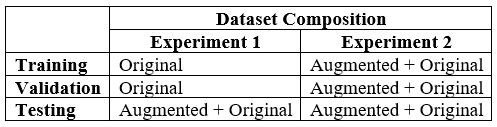

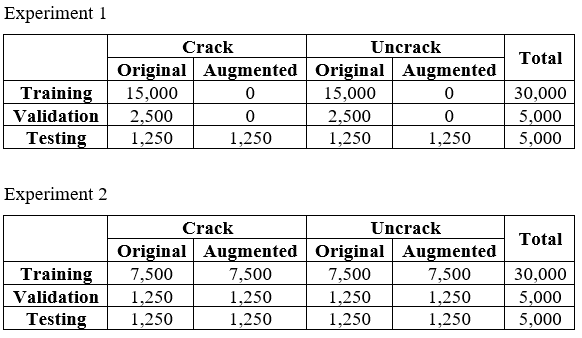

The distribution of images will be based on above tables.

**Dataset for Experiment 1**


In [16]:
# Building file structure in GDrive 
# Based on details in table for experiment 1
if copy_file == True:
  source_dir_op = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Original/Positive/*'
  source_dir_on = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Original/Negative/*'
  source_dir_ap = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Augmented/Positive/*'
  source_dir_an = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Dataset Augmented/Negative/*'

  destination_dir_train_p = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E1_Train/Positive'
  destination_dir_train_n = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E1_Train/Negative'
  destination_dir_val_p = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E1_Val/Positive'
  destination_dir_val_n = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E1_Val/Negative'
  destination_dir_test_p = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E1_Test/Positive'
  destination_dir_test_n = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E1_Test/Negative'

  # Training Set - Positive
  for file in glob.glob(source_dir_op)[0:15000]: # First 15,000 images (Ori)
    shutil.copy(file, destination_dir_train_p)

  # Training Set - Negative
  for file in glob.glob(source_dir_on)[0:15000]: # Following 15,000 images (Ori)
    shutil.copy(file, destination_dir_train_n)

  # Validation Set - Positive
  for file in glob.glob(source_dir_op)[15000:17500]: # First 2,500 images (Ori)
    shutil.copy(file, destination_dir_val_p)

  # Validation Set - Negative
  for file in glob.glob(source_dir_on)[15000:17500]: # Following 2,500 images (Ori)
    shutil.copy(file, destination_dir_val_n)

  # Testing Set - Positive
  for file in glob.glob(source_dir_op)[17500:18750]: # First 1,250 images (Ori)
    shutil.copy(file, destination_dir_test_p)
  for file in glob.glob(source_dir_ap)[17500:18750]: # Following 1,250 images (Aug)
    shutil.copy(file, destination_dir_test_p)

  # Testing Set - Negative
  for file in glob.glob(source_dir_on)[18750:20000]: # First 1,250 images (Ori)
    shutil.copy(file, destination_dir_test_n)
  for file in glob.glob(source_dir_an)[18750:20000]: # Following 1,250 images (Aug)
    shutil.copy(file, destination_dir_test_n)

In [17]:
# Checking number of saved images in Gdrive
if display_file == True:
  train_p = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E1_Train/Positive/*"))
  train_n = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E1_Train/Negative/*"))
  val_p = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E1_Val/Positive/*"))
  val_n = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E1_Val/Negative/*"))
  test_p = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E1_Test/Positive/*"))
  test_n = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E1_Test/Negative/*"))
  
  print('Quantity of positive class images in training set saved: ', train_p)
  print('Quantity of negative class images in training set saved: ', train_n)
  print('Quantity of positive class images in validation set saved: ', val_p)
  print('Quantity of negative class images in validation set saved: ', val_n)
  print('Quantity of positive class images in testing set saved: ', test_p)
  print('Quantity of negative class images in testing set saved: ', test_n)

**Dataset for Experiment 2**


In [18]:
# Building file structure in GDrive 
# Based on details in table for experiment 2
if copy_file == True:
  destination_dir_train_p = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E2_Train/Positive'
  destination_dir_train_n = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E2_Train/Negative'
  destination_dir_val_p = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E2_Val/Positive'
  destination_dir_val_n = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E2_Val/Negative'
  destination_dir_test_p = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E2_Test/Positive'
  destination_dir_test_n = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/E2_Test/Negative'

  # Training Set - Positive
  for file in glob.glob(source_dir_op)[0:7500]: # First 7,500 images (Ori)
    shutil.copy(file, destination_dir_train_p)
  for file in glob.glob(source_dir_ap)[7500:15000]: # Following 7,500 images (Aug)
    shutil.copy(file, destination_dir_train_p)

  # Training Set - Negative
  for file in glob.glob(source_dir_on)[0:7500]: # First 7,500 images (Ori)
    shutil.copy(file, destination_dir_train_n)
  for file in glob.glob(source_dir_an)[7500:15000]: # Following 7,500 images (Aug)
    shutil.copy(file, destination_dir_train_n)

  # Validation Set - Positive
  for file in glob.glob(source_dir_op)[15000:16250]: # First 1,250 images (Ori)
    shutil.copy(file, destination_dir_val_p)
  for file in glob.glob(source_dir_ap)[15000:16250]: # Following 1,250 images (Aug)
    shutil.copy(file, destination_dir_val_p)

  # Validation Set - Negative
  for file in glob.glob(source_dir_on)[16250:175000]: # First 1,250 images (Ori)
    shutil.copy(file, destination_dir_val_n)
  for file in glob.glob(source_dir_an)[16250:175000]: # Following 1,250 images (Aug)
    shutil.copy(file, destination_dir_val_n)

  # Testing Set - Positive
  for file in glob.glob(source_dir_op)[17500:18750]: # First 1,250 images (Ori)
    shutil.copy(file, destination_dir_test_p)
  for file in glob.glob(source_dir_ap)[17500:18750]: # Following 1,250 images (Aug)
    shutil.copy(file, destination_dir_test_p)

  # Testing Set - Negative
  for file in glob.glob(source_dir_on)[18750:20000]: # First 1,250 images (Ori)
    shutil.copy(file, destination_dir_test_n)
  for file in glob.glob(source_dir_an)[18750:20000]: # Following 1,250 images (Aug)
    shutil.copy(file, destination_dir_test_n)

In [19]:
# Checking number of saved images in Gdrive
if display_file == True:
  train_p = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E2_Train/Positive/*"))
  train_n = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E2_Train/Negative/*"))
  val_p = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E2_Val/Positive/*"))
  val_n = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E2_Val/Negative/*"))
  test_p = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E2_Test/Positive/*"))
  test_n = len(glob.glob("/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E2_Test/Negative/*"))
  
  print('Quantity of positive class images in training set saved: ', train_p)
  print('Quantity of negative class images in training set saved: ', train_n)
  print('Quantity of positive class images in validation set saved: ', val_p)
  print('Quantity of negative class images in validation set saved: ', val_n)
  print('Quantity of positive class images in testing set saved: ', test_p)
  print('Quantity of negative class images in testing set saved: ', test_n)

#### 2.3.2 Data Generator

1. Original image size is 227x227.
2. Image is to be resized to 224x224 to fit the **GoogleNet architecture**.
3. Dividing pixel value by 255 to convert the value range between 0 and 1.
4. The numbers are small and computation becomes easier and faster.

In [20]:
def my_generator(generator):
  while True: # keras requires all generators to be infinite
    data = next(generator)
    x = data[0]
    y = data[1]
    yield x, y

**Data Generator Experiment 1**

In [21]:
batch_size = 50

# Folder paths
path_train_e1 = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E1_Train'
path_val_e1 = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E1_Val'
path_test_e1 = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E1_Test'

# Datagen arguments for pixel normalization
datagen_args = ImageDataGenerator(rescale=1./255)

# Training set Data Generator
train_generator_e1 = datagen_args.flow_from_directory(path_train_e1,
                                                      target_size=(224, 224),
                                                      color_mode='grayscale',
                                                      batch_size=batch_size)

# Validation set Data Generator
val_generator_e1 = datagen_args.flow_from_directory(path_val_e1,
                                                    target_size=(224, 224),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size)

# Testing set Data Generator
test_generator_e1 = datagen_args.flow_from_directory(path_test_e1,
                                                     target_size=(224, 224),
                                                     color_mode='grayscale',
                                                     shuffle=False,
                                                     batch_size=1)

Found 30000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [22]:
# Checking data shape and type
x1, y1 = next(train_generator_e1)
print('x: ', type(x1))
print('y: ', type(y1))
print('x: ', x1.shape)
print('y: ', y1.shape)

# Class Index
print(train_generator_e1.class_indices)

x:  <class 'numpy.ndarray'>
y:  <class 'numpy.ndarray'>
x:  (50, 224, 224, 1)
y:  (50, 2)
{'Negative': 0, 'Positive': 1}


In [23]:
# Data prep
train_e1 = my_generator(train_generator_e1)
val_e1 = my_generator(val_generator_e1)
test_e1 = my_generator(test_generator_e1)

**Data Generator Experiment 2**

In [24]:
# Folder paths
path_train_e2 = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E2_Train'
path_val_e2 = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E2_Val'
path_test_e2 = '/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Data Generator/E2_Test'

# Datagen arguments for pixel normalization
datagen_args = ImageDataGenerator(rescale=1./255)

# Training set Data Generator
train_generator_e2 = datagen_args.flow_from_directory(path_train_e2,
                                                      target_size=(224, 224),
                                                      color_mode='grayscale',
                                                      batch_size=batch_size)

# Validation set Data Generator
val_generator_e2 = datagen_args.flow_from_directory(path_val_e2,
                                                    target_size=(224, 224),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size)

# Testing set Data Generator
test_generator_e2 = datagen_args.flow_from_directory(path_test_e2,
                                                     target_size=(224, 224),
                                                     color_mode='grayscale',
                                                     shuffle=False,
                                                     batch_size=1)

Found 30000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [25]:
# Checking data shape and type
x2, y2 = next(train_generator_e2)
print('x: ', type(x2))
print('y: ', type(y2))
print('x: ', x2.shape)
print('y: ', y2.shape)

# Class Index
print(train_generator_e2.class_indices)

x:  <class 'numpy.ndarray'>
y:  <class 'numpy.ndarray'>
x:  (50, 224, 224, 1)
y:  (50, 2)
{'Negative': 0, 'Positive': 1}


In [26]:
# Data prep
train_e2 = my_generator(train_generator_e2)
val_e2 = my_generator(val_generator_e2)
test_e2 = my_generator(test_generator_e2)

### 2.4 Data Visualization







**Dataset Visualization of Experiment 1**

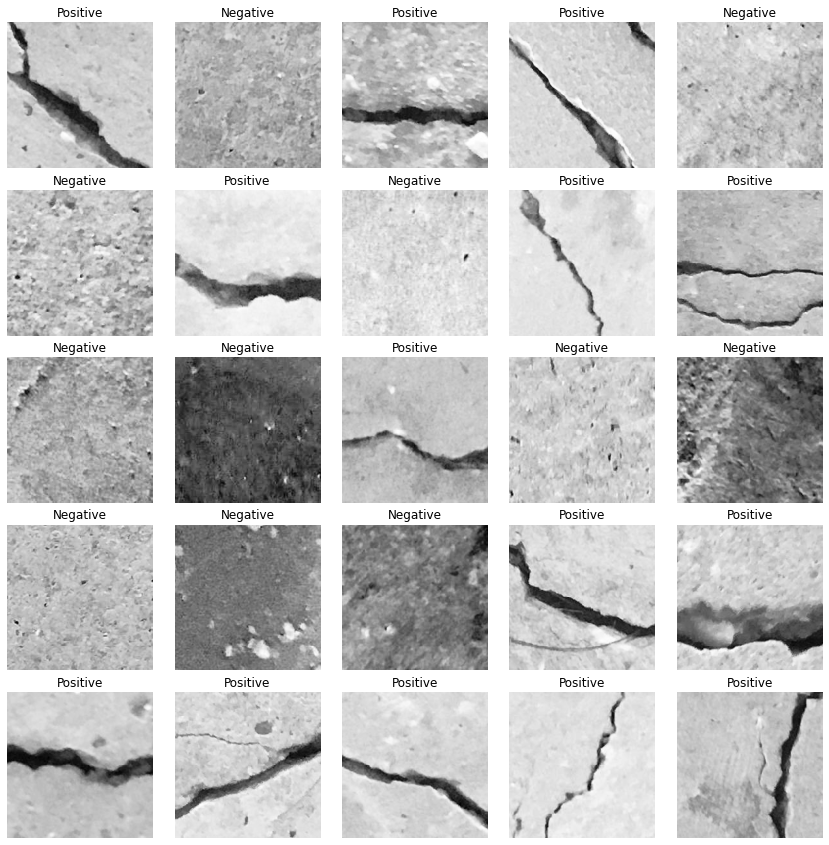

In [27]:
# Arguments for show_grid (class_mapping and y_int)
# variable name must not change
class_mapping = {v:k for k,v in train_generator_e1.class_indices.items()}
y_int = np.argmax(y1,axis=-1)

# Visualize data samples from dataset of experiment 1
show_grid(x1, 5,5,
          label_list=y_int,
          show_labels=True,
          figsize=(15, 15))

**Dataset Visualization of Experiment 2**

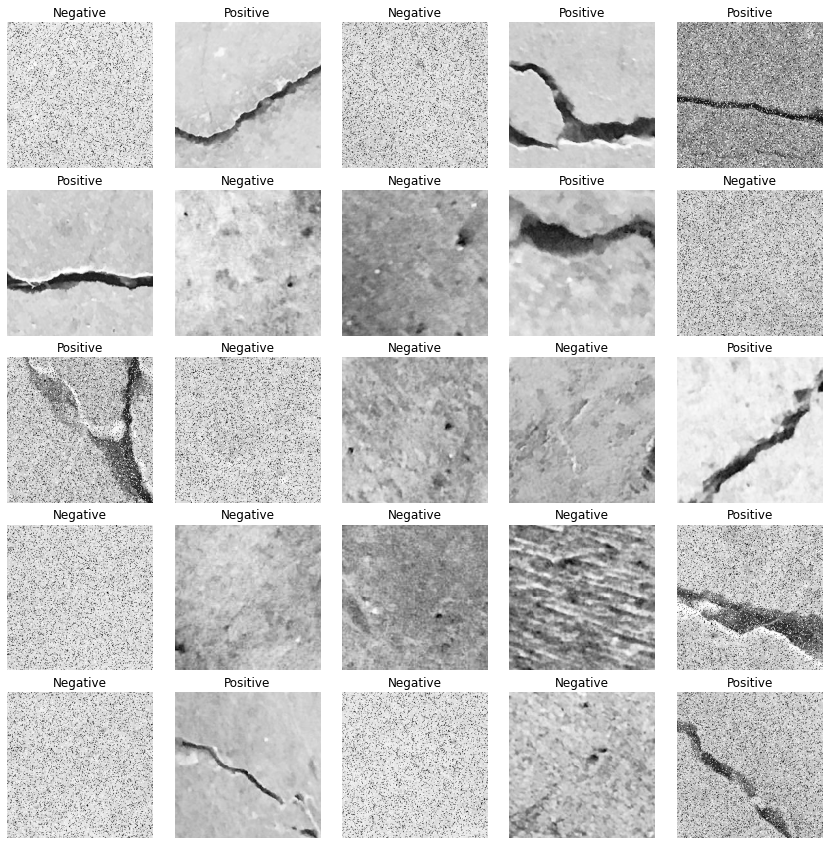

In [28]:
# Arguments for show_grid (class_mapping and y_int)
# variable name must not change
class_mapping = {v:k for k,v in train_generator_e1.class_indices.items()}
y_int = np.argmax(y2,axis=-1)

# Visualize data samples from dataset of experiment 2
show_grid(x2, 5,5,
          label_list=y_int,
          show_labels=True,
          figsize=(15, 15))

## 3.0 Model Development
1. GoogleNet architecture not utilizing anymore.


**Using verySimpleCNN**

In [ ]:
# A simple CNN architecture with 3 layers of convolution and
# Uses global average pooling in replace to fully connected layer 
def verySimpleCNN():
  model = Sequential()
  # Convolutional 1 - 32 neurons with 3x3 filters
  model.add(Conv2D(32,3,padding="same", activation="relu", input_shape = (224,224,1)))
  model.add(MaxPool2D())
  # Convolutional 2
  model.add(Conv2D(64, 3, padding="same", activation="relu"))
  model.add(MaxPool2D())
  # Convolutional 3
  model.add(Conv2D(128, 3, padding="same", activation="relu"))
  model.add(MaxPool2D())
  # Global average pooling replacing dense layer
  model.add(GlobalAveragePooling2D())
  # Output
  model.add(Dense(2, activation="softmax"))

  return model

In [ ]:
model = verySimpleCNN()

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### 3.1 Image Classifier with Dataset from Experiment 1

**Iterating hyperparameters**

Learning rate: 1e-3, 1e-4, 1e-5, 1e-6 

Epochs: 10, 20, 30

Learning rate too low may inhibit model to learn anything.
Learning rate too high will cause high oscillation in loss.

In [ ]:
# Loop for training and saving models
# Based on the iterating hyperparameters

for epochs in (10, 20, 30): # 10, 20, 30
  for learning_rate in (1e-3, 1e-4, 1e-5, 1e-6): # 1e-3, 1e-4, 1e-5, 1e-6
    
    keras.backend.clear_session()
    model = verySimpleCNN()

    # Optimizer learning rate setting
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compiler
    model.compile(loss=['categorical_crossentropy'],
                  optimizer=opt,
                  metrics=['accuracy'])

    # Model fitting
    model_fit = model.fit(train_e1,
                          steps_per_epoch=math.ceil(train_generator_e1.samples // batch_size),
                          epochs=epochs,
                          validation_data=val_e1,
                          validation_steps=math.ceil(val_generator_e1.samples // batch_size))

    # Producing model history
    model_history = model.history.history

    # Setting file name
    save_name = f'Experiment1-{epochs}Epochs-{learning_rate}LearningRate'

    # Saving trained model and history
    print(f'Saving model history in GDrive folder as : {save_name}')
    history_path = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved History/E1/{save_name}'

    with open(history_path, 'wb') as f:
      pickle.dump(model_history, f)

    print(f'Saving trained model in GDrive folder as: {save_name}')
    model_path = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved Model/E1/{save_name}'
    model.save(model_path, save_format='h5')

    # Plotting model loss
    loss = model_history['loss']
    val_loss = model_history['val_loss']

    plt.figure(figsize=(10, 10))
    plt.plot(loss, c='red')
    plt.plot(val_loss, c='blue')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    #plt.gca().set_ylim(2,2.5)
    plt.show()                      

### 3.2 Image Classifier with Dataset from Experiment 2

**Iterating hyperparameters**

Learning rate: 1e-2, 1e-3, 1e-4, 1e-5 

Epochs: 10, 20, 30

In [ ]:
# Loop for training and saving models
# Based on the iterating hyperparameters

for epochs in (10, 20, 30): # 10, 20, 30, 50, 100
  for learning_rate in (1e-3, 1e-4, 1e-5, 1e-6): # 1e-3, 1e-4, 1e-5, 1e-6
    
    keras.backend.clear_session()
    model = verySimpleCNN()

    # Optimizer learning rate setting
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compiler
    model.compile(loss=['categorical_crossentropy'],
                  optimizer=opt,
                  metrics=['accuracy'])

    # Model fitting
    model_fit = model.fit(train_e2,
                          steps_per_epoch=math.ceil(train_generator_e2.samples // batch_size),
                          epochs=epochs,
                          validation_data=val_e2,
                          validation_steps=math.ceil(val_generator_e2.samples // batch_size))

    # Producing model history
    model_history = model.history.history

    # Setting file name
    save_name = f'Experiment2-{epochs}Epochs-{learning_rate}LearningRate'

    # Saving trained model and history
    print(f'Saving model history in GDrive folder as : {save_name}')
    history_path = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved History/E2/{save_name}'

    with open(history_path, 'wb') as f:
      pickle.dump(model_history, f)

    print(f'Saving trained model in GDrive folder as: {save_name}')
    model_path = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved Model/E2/{save_name}'
    model.save(model_path, save_format='h5')

    # Plotting model loss
    loss = model_history['loss']
    val_loss = model_history['val_loss']

    plt.figure(figsize=(10, 10))
    plt.plot(loss, c='red')
    plt.plot(val_loss, c='blue')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    #plt.gca().set_ylim(2,2.5)
    plt.show()                      

## 4.0 Model Evaluation

1. Performance of the image classification will be evaluated and compared.
2. Retrieve saved model.
2. Evaluation metrics include confusion matrix, sensitivty, specificity, and accuracy.

### 4.1 Evaluation - Experiment 1

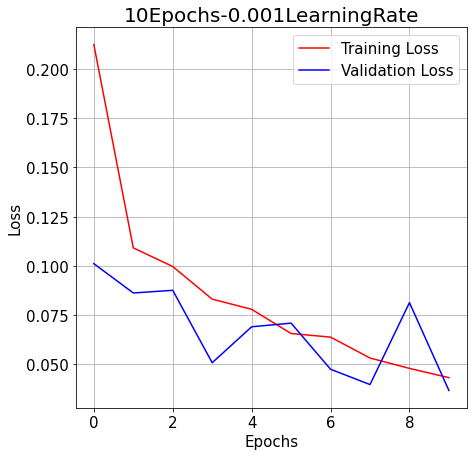

Final training loss: 0.04328036680817604
Final training loss: 0.036764103919267654
10Epochs-0.001LearningRate
5000/5000 [==============================] - 594s 119ms/step

Accuracy:  0.7454
Precision:  0.663644
Recall:  0.9952
[[1239 1261]
 [  12 2488]]


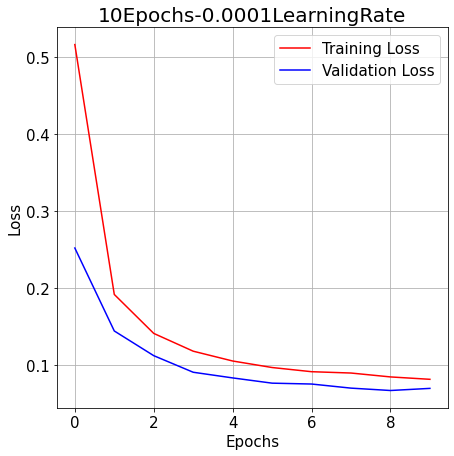

Final training loss: 0.08089247345924377
Final training loss: 0.06910329312086105
10Epochs-0.0001LearningRate
5000/5000 [==============================] - 173s 35ms/step

Accuracy:  0.7386
Precision:  0.661173
Recall:  0.9788
[[1246 1254]
 [  53 2447]]


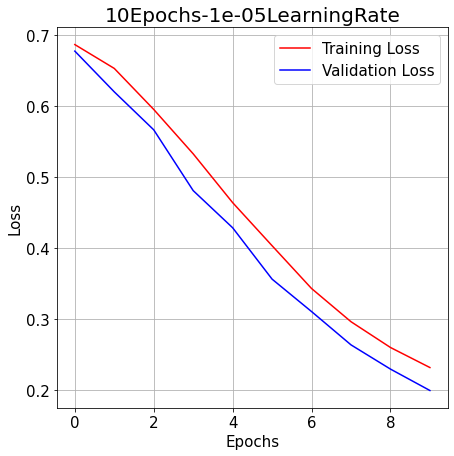

Final training loss: 0.23167471587657928
Final training loss: 0.19929690659046173
10Epochs-1e-05LearningRate
5000/5000 [==============================] - 173s 35ms/step

Accuracy:  0.7248
Precision:  0.652717
Recall:  0.9608
[[1222 1278]
 [  98 2402]]


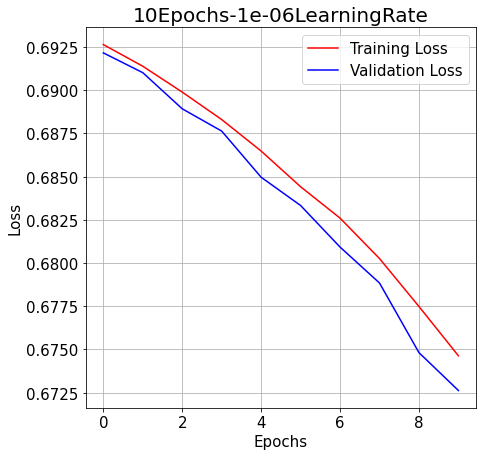

Final training loss: 0.6746318936347961
Final training loss: 0.6726232171058655
10Epochs-1e-06LearningRate
5000/5000 [==============================] - 175s 35ms/step

Accuracy:  0.6184
Precision:  0.589534
Recall:  0.7796
[[1143 1357]
 [ 551 1949]]


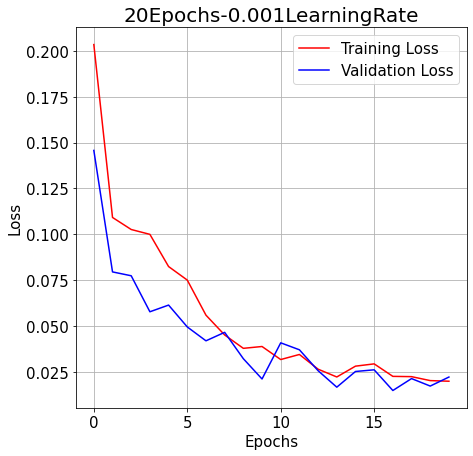

Final training loss: 0.020101604983210564
Final training loss: 0.02237575687468052
20Epochs-0.001LearningRate
5000/5000 [==============================] - 175s 35ms/step

Accuracy:  0.9554
Precision:  0.966407
Recall:  0.9436
[[2418   82]
 [ 141 2359]]


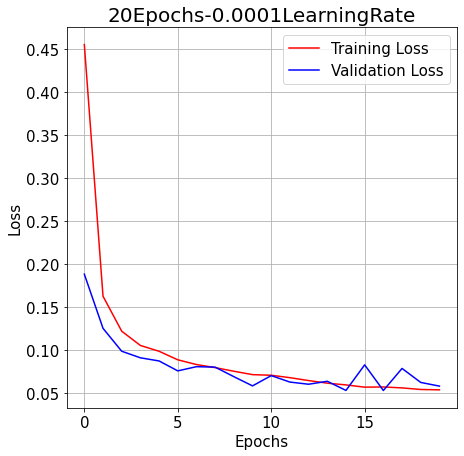

Final training loss: 0.05381818488240242
Final training loss: 0.05813806131482124
20Epochs-0.0001LearningRate
5000/5000 [==============================] - 177s 35ms/step

Accuracy:  0.7418
Precision:  0.662719
Recall:  0.9848
[[1247 1253]
 [  38 2462]]


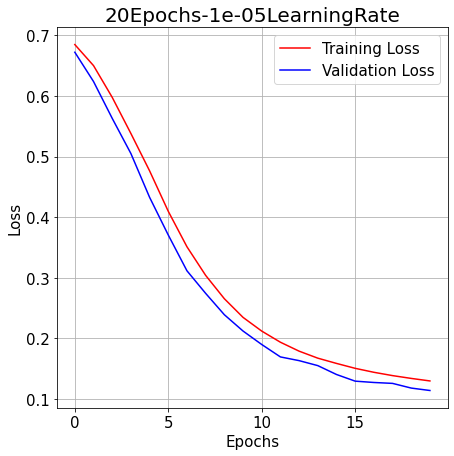

Final training loss: 0.12994134426116943
Final training loss: 0.11416803300380707
20Epochs-1e-05LearningRate
5000/5000 [==============================] - 180s 36ms/step

Accuracy:  0.7338
Precision:  0.658016
Recall:  0.9736
[[1235 1265]
 [  66 2434]]


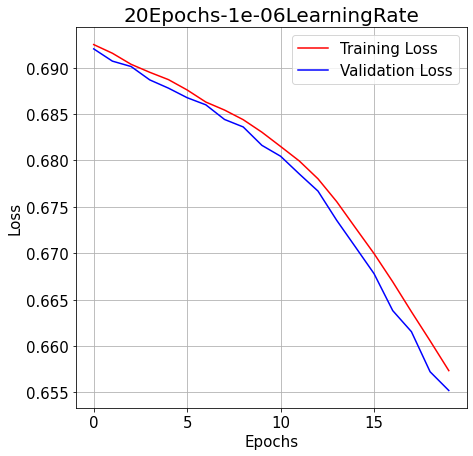

Final training loss: 0.657354474067688
Final training loss: 0.6552132964134216
20Epochs-1e-06LearningRate
5000/5000 [==============================] - 180s 36ms/step

Accuracy:  0.631
Precision:  0.594028
Recall:  0.8276
[[1086 1414]
 [ 431 2069]]


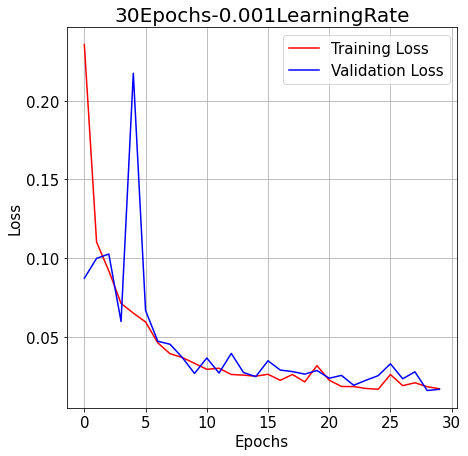

Final training loss: 0.0167945995926857
Final training loss: 0.0164700448513031
30Epochs-0.001LearningRate
5000/5000 [==============================] - 179s 36ms/step

Accuracy:  0.9388
Precision:  0.986259
Recall:  0.89
[[2469   31]
 [ 275 2225]]


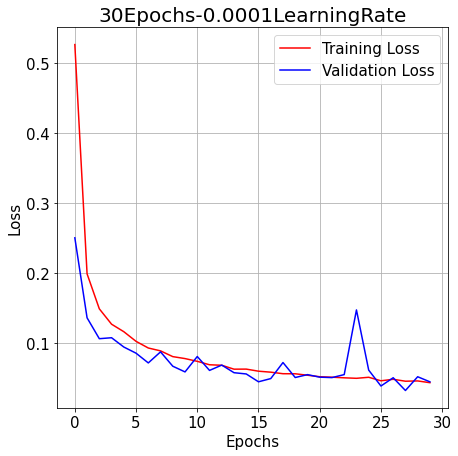

Final training loss: 0.04385228455066681
Final training loss: 0.04507893696427345
30Epochs-0.0001LearningRate
5000/5000 [==============================] - 180s 36ms/step

Accuracy:  0.7414
Precision:  0.662712
Recall:  0.9832
[[1249 1251]
 [  42 2458]]


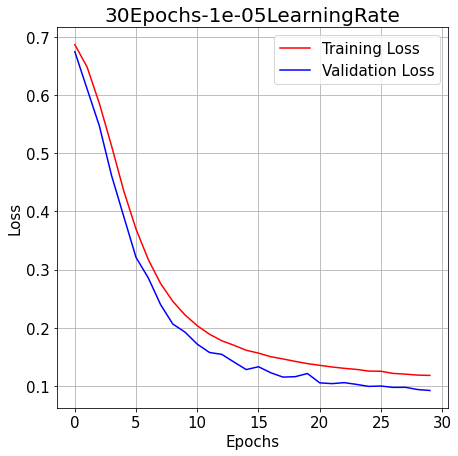

Final training loss: 0.11781841516494751
Final training loss: 0.09187562763690948
30Epochs-1e-05LearningRate
5000/5000 [==============================] - 181s 36ms/step

Accuracy:  0.7374
Precision:  0.659844
Recall:  0.98
[[1237 1263]
 [  50 2450]]


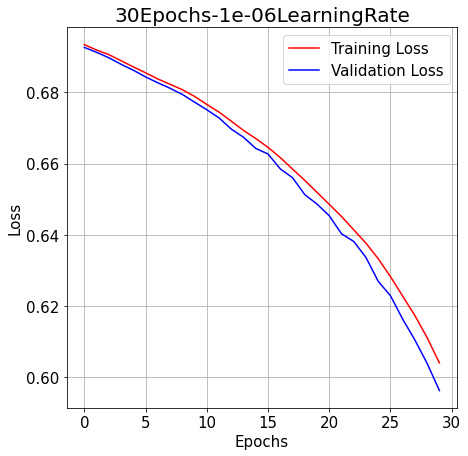

Final training loss: 0.6039953231811523
Final training loss: 0.5962536931037903
30Epochs-1e-06LearningRate
5000/5000 [==============================] - 183s 37ms/step

Accuracy:  0.6518
Precision:  0.601661
Recall:  0.8984
[[1013 1487]
 [ 254 2246]]


In [ ]:
path_history = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved History/E1/*'
path_model = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved Model/E1/*'

history_list = []
history_name = []
model_name = []
model_idx = []
cntr = 0

# Loading model history
for file in glob.glob(path_history):
  # Save string name for showing model architecture
  history_name.append(file.split('Experiment1-',1)[1])
  with open(file, 'rb') as input:
    history_load = pickle.load(input)

    # Plot training loss and validation loss
    plt.figure(figsize=(7,7))
    plt.plot(history_load['loss'], c='red')
    plt.plot(history_load['val_loss'], c='blue')
    plt.legend(['Training Loss', 'Validation Loss'], prop={'size':15})
    plt.title(history_name[cntr], fontsize=20)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.show()
    history_list.append(history_load)

    # Print loss and validation loss of last epoch
    print('Final training loss:', history_load['loss'][-1])
    print('Final training loss:', history_load['val_loss'][-1])

  # Loading saved model
  model_file = glob.glob(path_model)[cntr]
  model_load = load_model(model_file)
  print(model_file.split('Experiment1-',1)[1])

  # Model inference based on testing set
  # Data shuffle=False, we know first 2500 data is negative, next 2500 data is positive
  y_true = np.array([0] * 2500 + [1] * 2500) # Creating y-test actual labels
  y_pred = model_load.predict(test_generator_e1, steps=5000)

  probabilities = y_pred < 0.5
  probabilities = probabilities[:,0]
  
  # Model Evaluation Metrics
  acc = accuracy_score(y_true, probabilities)
  precision = precision_score(y_true, probabilities)
  recall = recall_score(y_true, probabilities)
  cm = confusion_matrix(y_true, probabilities)
  
  print('\nAccuracy: ', round(acc, 6))
  print('Precision: ', round(precision, 6))
  print('Recall: ', round(recall, 6))
  print(cm)

  cntr += 1


### 4.2 Evaluation - Experiment 2

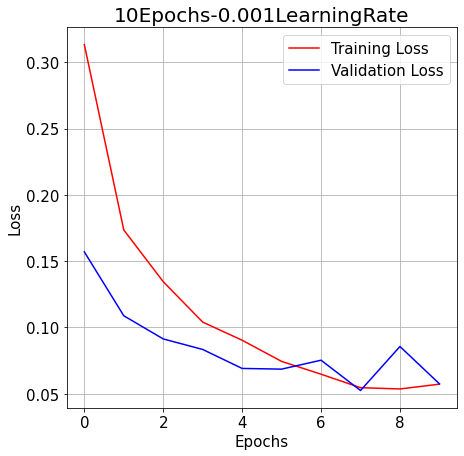

Final training loss: 0.057141244411468506
Final training loss: 0.05740424990653992
10Epochs-0.001LearningRate
5000/5000 [==============================] - 823s 165ms/step

Accuracy:  0.9808
Precision:  0.996694
Recall:  0.9648
[[2492    8]
 [  88 2412]]


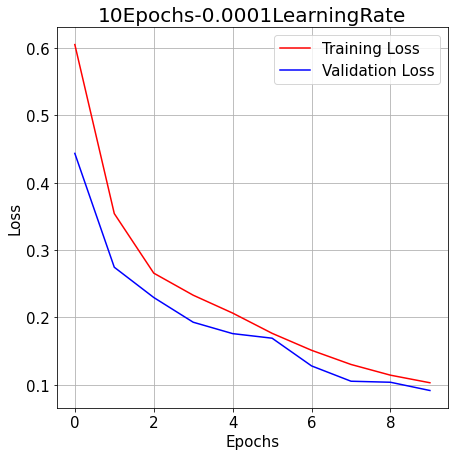

Final training loss: 0.10309428721666336
Final training loss: 0.09159975498914719
10Epochs-0.0001LearningRate
5000/5000 [==============================] - 172s 34ms/step

Accuracy:  0.9712
Precision:  0.989203
Recall:  0.9528
[[2474   26]
 [ 118 2382]]


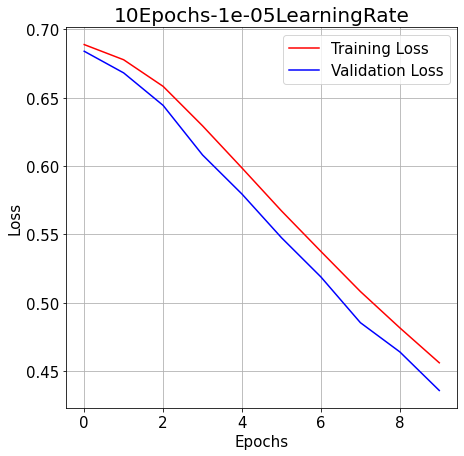

Final training loss: 0.45594316720962524
Final training loss: 0.43565165996551514
10Epochs-1e-05LearningRate
5000/5000 [==============================] - 172s 34ms/step

Accuracy:  0.85
Precision:  0.921078
Recall:  0.7656
[[2336  164]
 [ 586 1914]]


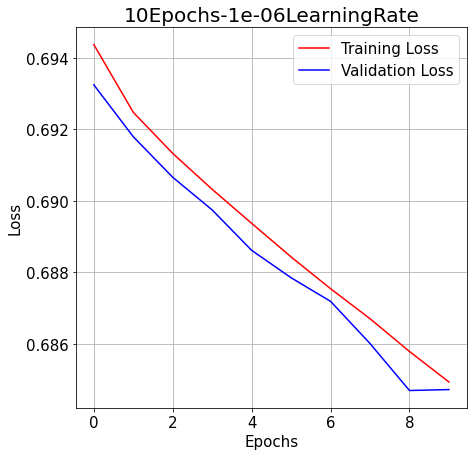

Final training loss: 0.6849311590194702
Final training loss: 0.6847178339958191
10Epochs-1e-06LearningRate
5000/5000 [==============================] - 174s 35ms/step

Accuracy:  0.6558
Precision:  0.754742
Recall:  0.4616
[[2125  375]
 [1346 1154]]


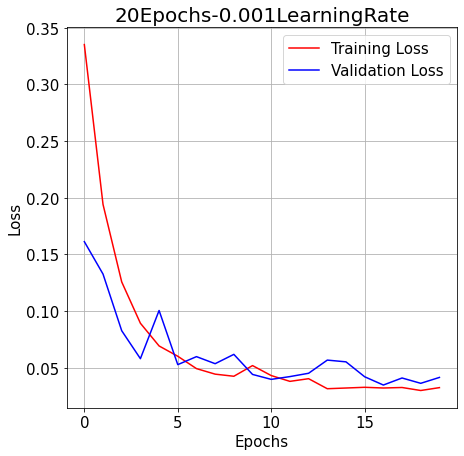

Final training loss: 0.032332129776477814
Final training loss: 0.04133555293083191
20Epochs-0.001LearningRate
5000/5000 [==============================] - 176s 35ms/step

Accuracy:  0.9896
Precision:  0.998371
Recall:  0.9808
[[2496    4]
 [  48 2452]]


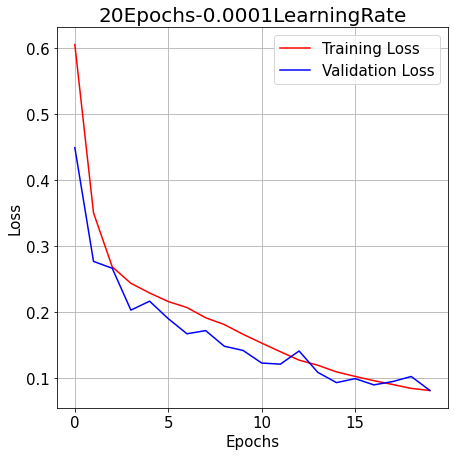

Final training loss: 0.08126891404390335
Final training loss: 0.08121846616268158
20Epochs-0.0001LearningRate
5000/5000 [==============================] - 175s 35ms/step

Accuracy:  0.9776
Precision:  0.988543
Recall:  0.9664
[[2472   28]
 [  84 2416]]


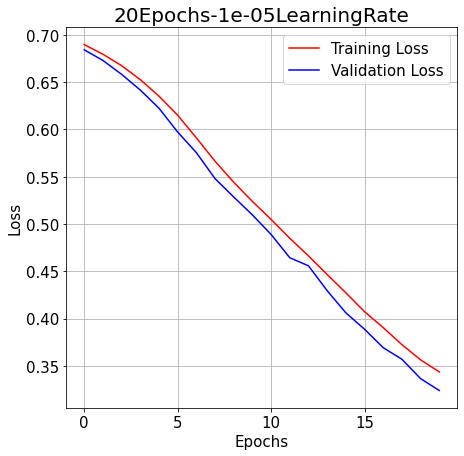

Final training loss: 0.3435229957103729
Final training loss: 0.32388898730278015
20Epochs-1e-05LearningRate
5000/5000 [==============================] - 176s 35ms/step

Accuracy:  0.8996
Precision:  0.958678
Recall:  0.8352
[[2410   90]
 [ 412 2088]]


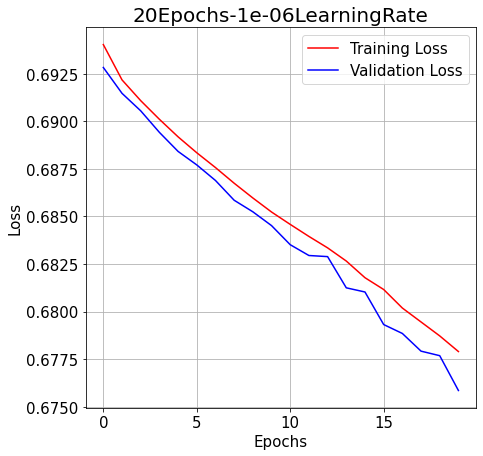

Final training loss: 0.6778960824012756
Final training loss: 0.6758489012718201
20Epochs-1e-06LearningRate
5000/5000 [==============================] - 178s 36ms/step

Accuracy:  0.6552
Precision:  0.756275
Recall:  0.458
[[2131  369]
 [1355 1145]]


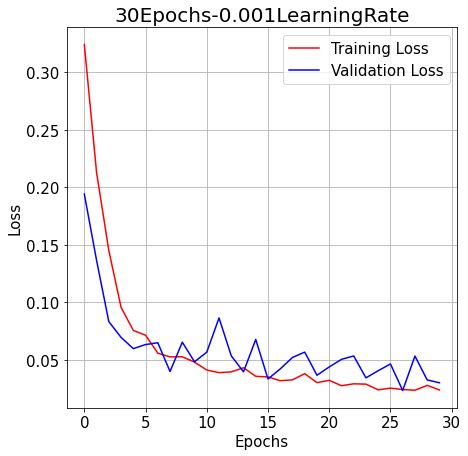

Final training loss: 0.023979386314749718
Final training loss: 0.030214102938771248
30Epochs-0.001LearningRate
5000/5000 [==============================] - 177s 35ms/step

Accuracy:  0.9922
Precision:  0.994773
Recall:  0.9896
[[2487   13]
 [  26 2474]]


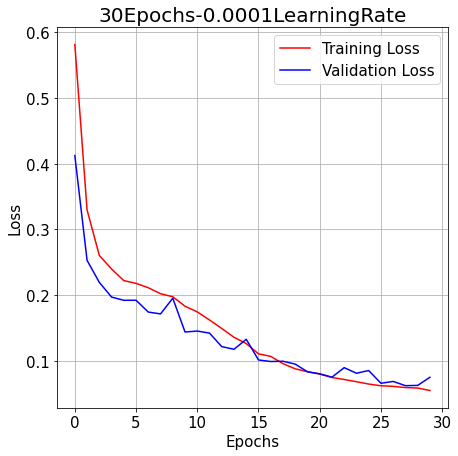

Final training loss: 0.05502913519740105
Final training loss: 0.07516679167747498
30Epochs-0.0001LearningRate
5000/5000 [==============================] - 179s 36ms/step

Accuracy:  0.9762
Precision:  0.995422
Recall:  0.9568
[[2489   11]
 [ 108 2392]]


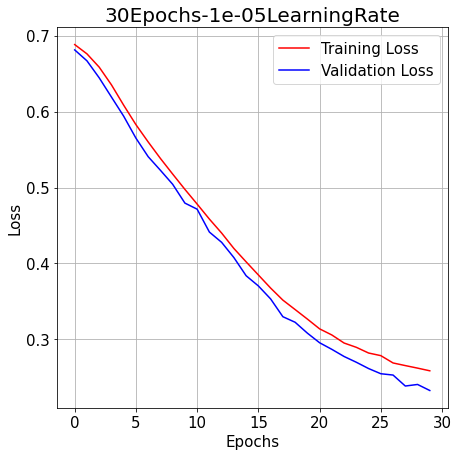

Final training loss: 0.2587588429450989
Final training loss: 0.2328292280435562
30Epochs-1e-05LearningRate
5000/5000 [==============================] - 179s 36ms/step

Accuracy:  0.9264
Precision:  0.979317
Recall:  0.8712
[[2454   46]
 [ 322 2178]]


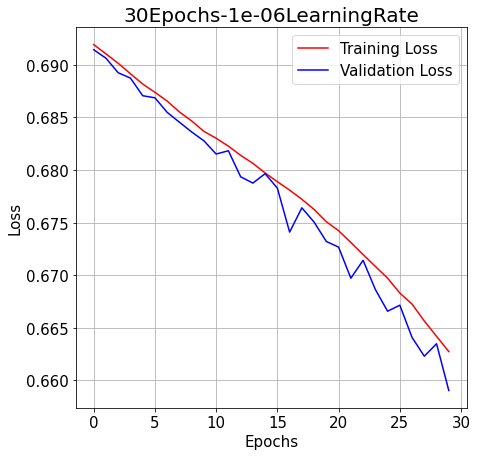

Final training loss: 0.6627361178398132
Final training loss: 0.6590374708175659
30Epochs-1e-06LearningRate
5000/5000 [==============================] - 180s 36ms/step

Accuracy:  0.6628
Precision:  0.783426
Recall:  0.45
[[2189  311]
 [1375 1125]]


In [ ]:
path_history = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved History/E2/*'
path_model = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved Model/E2/*'

history_list = []
history_name = []
model_name = []
model_idx = []
cntr = 0

# Loading model history
for file in glob.glob(path_history):
  # Save string name for showing model architecture
  history_name.append(file.split('Experiment2-',1)[1])
  with open(file, 'rb') as input:
    history_load = pickle.load(input)

    # Plot training loss and validation loss
    plt.figure(figsize=(7,7))
    plt.plot(history_load['loss'], c='red')
    plt.plot(history_load['val_loss'], c='blue')
    plt.legend(['Training Loss', 'Validation Loss'], prop={'size':15})
    plt.title(history_name[cntr], fontsize=20)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.show()
    history_list.append(history_load)

    # Print loss and validation loss of last epoch
    print('Final training loss:', history_load['loss'][-1])
    print('Final training loss:', history_load['val_loss'][-1])

  # Loading saved model
  model_file = glob.glob(path_model)[cntr]
  model_load = load_model(model_file)
  print(model_file.split('Experiment2-',1)[1])

  # Model inference based on testing set
  # Data shuffle=False, we know first 2500 data is negative, next 2500 data is positive
  y_true = np.array([0] * 2500 + [1] * 2500) # Creating y-test actual labels
  y_pred = model_load.predict(test_generator_e2, steps=5000)

  probabilities = y_pred < 0.5
  probabilities = probabilities[:,0]
  
  # Model Evaluation Metrics
  acc = accuracy_score(y_true, probabilities)
  precision = precision_score(y_true, probabilities)
  recall = recall_score(y_true, probabilities)
  cm = confusion_matrix(y_true, probabilities)
  
  print('\nAccuracy: ', round(acc, 6))
  print('Precision: ', round(precision, 6))
  print('Recall: ', round(recall, 6))
  print(cm)

  cntr += 1

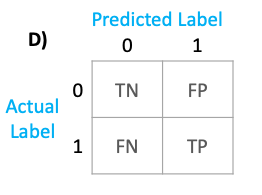

### 4.3 Return images of false negatives by Model E2-9


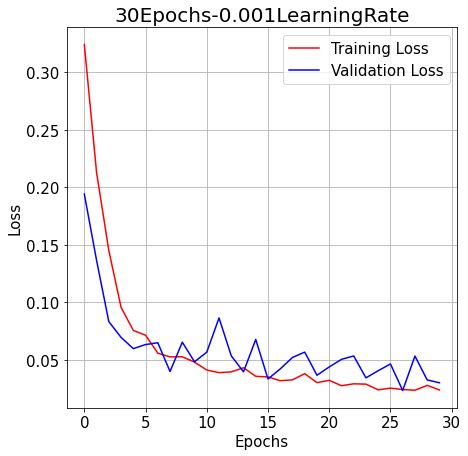

Final training loss: 0.023979386314749718
Final training loss: 0.030214102938771248
30Epochs-0.001LearningRate
5000/5000 [==============================] - 830s 166ms/step

Accuracy:  0.9922
Precision:  0.994773
Recall:  0.9896
[[2487   13]
 [  26 2474]]


In [ ]:
path_history = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved History/E2/Experiment2-30Epochs-0.001LearningRate'
path_model = f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved Model/E2/Experiment2-30Epochs-0.001LearningRate'

history_list = []
history_name = []
model_name = []
model_idx = []
cntr = 0

# Loading model history
for file in glob.glob(path_history):
  # Save string name for showing model architecture
  history_name.append(file.split('Experiment2-',1)[1])
  with open(file, 'rb') as input:
    history_load = pickle.load(input)

    # Plot training loss and validation loss
    plt.figure(figsize=(7,7))
    plt.plot(history_load['loss'], c='red')
    plt.plot(history_load['val_loss'], c='blue')
    plt.legend(['Training Loss', 'Validation Loss'], prop={'size':15})
    plt.title(history_name[cntr], fontsize=20)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.show()
    history_list.append(history_load)

    # Print loss and validation loss of last epoch
    print('Final training loss:', history_load['loss'][-1])
    print('Final training loss:', history_load['val_loss'][-1])

  # Loading saved model
  model_file = glob.glob(path_model)[cntr]
  model_load = load_model(model_file)
  print(model_file.split('Experiment2-',1)[1])

  # Model inference based on testing set
  # Data shuffle=False, we know first 2500 data is negative, next 2500 data is positive
  y_true = np.array([0] * 2500 + [1] * 2500) # Creating y-test actual labels
  y_pred = model_load.predict(test_generator_e2, steps=5000)

  probabilities = y_pred < 0.5
  probabilities = probabilities[:,0]
  
  # Model Evaluation Metrics
  acc = accuracy_score(y_true, probabilities)
  precision = precision_score(y_true, probabilities)
  recall = recall_score(y_true, probabilities)
  cm = confusion_matrix(y_true, probabilities)
  
  print('\nAccuracy: ', round(acc, 6))
  print('Precision: ', round(precision, 6))
  print('Recall: ', round(recall, 6))
  print(cm)

  cntr += 1

In [ ]:
# Identify index of false negatives in Model E2-9
idx = []
for i in range(len(y_true)):
  if probabilities[i] == False and y_true[i] == 1:
    idx.append(i)

In [ ]:
# Plot all images based on previous index
for i in idx:
  img = test_generator_e2[i]
  img = np.array(img[0])
  img = img[0].reshape(224, 224, 1)
  img = np.squeeze(img)
  plt.imshow(img, cmap='gray')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

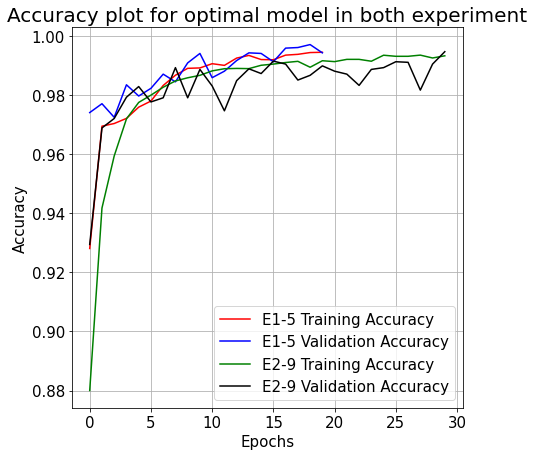

Final training loss: 0.023979386314749718
Final training loss: 0.030214102938771248


In [42]:
path_history = [f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved History/E1/Experiment1-20Epochs-0.001LearningRate',
                f'/content/drive/MyDrive/Colab Notebooks/APU - Deep Learning/Assignment/Saved History/E2/Experiment2-30Epochs-0.001LearningRate']

history_list = []
history_name = []
grand_hist = []
model_idx = []
cntr = 0

# Loading model history
for file in path_history:
  # Save string name for showing model architecture
  #history_name.append(file.split('Experiment2-',1)[1])
  with open(file, 'rb') as input:
    history_load = pickle.load(input)
  grand_hist.append(history_load)


# Plot training accuracy and validation accuracy
plt.figure(figsize=(7,7))
plt.plot(grand_hist[0]['accuracy'], c='red', label='E1-5 Training Accuracy')
plt.plot(grand_hist[0]['val_accuracy'], c='blue', label='E1-5 Validation Accuracy')
plt.plot(grand_hist[1]['accuracy'], c='green', label='E2-9 Training Accuracy')
plt.plot(grand_hist[1]['val_accuracy'], c='k', label='E2-9 Validation Accuracy')
plt.legend(prop={'size':15})
plt.title('Accuracy plot for optimal model in both experiment', fontsize=20)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()
history_list.append(history_load)

# Print loss and validation loss of last epoch
print('Final training loss:', history_load['loss'][-1])
print('Final training loss:', history_load['val_loss'][-1])

In [30]:
history_load

{'loss': [0.32397547364234924,
  0.2127947211265564,
  0.14506788551807404,
  0.09576326608657837,
  0.07569339871406555,
  0.07148493081331253,
  0.0559292733669281,
  0.05266804248094559,
  0.05281569063663483,
  0.048148613423109055,
  0.041284382343292236,
  0.03898657113313675,
  0.03966768831014633,
  0.04325292259454727,
  0.035818543285131454,
  0.0352792963385582,
  0.03198312968015671,
  0.03272724151611328,
  0.03811015188694,
  0.03031517006456852,
  0.032351911067962646,
  0.0276661179959774,
  0.029306815937161446,
  0.029008999466896057,
  0.024082420393824577,
  0.025558941066265106,
  0.024355877190828323,
  0.02373955398797989,
  0.02792333997786045,
  0.023979386314749718],
 'accuracy': [0.8799999952316284,
  0.9416999816894531,
  0.9593333601951599,
  0.9718666672706604,
  0.9774333238601685,
  0.9799000024795532,
  0.9825666546821594,
  0.9847000241279602,
  0.9857666492462158,
  0.9865999817848206,
  0.988099992275238,
  0.9888333082199097,
  0.9889333248138428,
 

In [ ]:
!jupyter nbconvert --to html /content/TP065778_LeeKeanLim_DL.ipynb

[NbConvertApp] Converting notebook /content/TP065778_LeeKeanLim_DL.ipynb to html
[NbConvertApp] Writing 3324269 bytes to /content/TP065778_LeeKeanLim_DL.html
